# Projeto WPT Eletromagnetismo - 2023.2 - Prof. Carlos Marmo
#### - Gustavo Eliziario Stevenson de Oliveira
#### - Alberto Carrera
#### - Pedro Civita
#### - Bruno Falcao

In [20]:
#Imports para o projeto
import numpy as np
from cmath import *
from numpy import linalg
import matplotlib.pyplot as plt

### Funções do projeto WPT (Wireless Power Transfer)

In [21]:
# R1, R2, Rc => Resistências das bobinas primárias e secundárias
# L1 = L2 = L => A indutância das bobinas é igual
# M = sqrt(L1*L2) => Indutância mútua
# C1 = C2 = C => A capacitância dos capacitores é igual
# k => Coeficiente de acoplamento

#Função para cálculo da corrente no primário e secundário
def CalcularTransformador_projeto(Uf, R1, R2, Rc, L, C, k, f):
    w = 2*pi*f
    XL = 1j*w*L
    XC = 1/(1j*w*C)
    M = k*L
    XM = 1j*w*M
    Z=np.array([[R1+XL+XC, -XM],[-XM, XL+R2+((Rc*XC)/(Rc+XC))]])
    V=np.array([Uf,0])
    i=np.dot(linalg.inv(Z),V)
    return i[0], i[1]

#Função para cálculo da corrente no primário e secundário com indutâncias diferentes - Condições Reais do Projeto
def CalcularTransformador_projeto2(Uf, R1, R2, Rc, L1, L2, C, k, f):
    w = 2*pi*f
    XL1 = 1j*w*L1
    XL2 = 1j*w*L2
    XC = 1/(1j*w*C)
    M = k*(sqrt(L1*L2))
    XM = 1j*w*M
    Z=np.array([[R1+XL1+XC, -XM],[-XM, XL2+R2+((Rc*XC)/(Rc+XC))]])
    V=np.array([Uf,0])
    i=np.dot(linalg.inv(Z),V)
    return i[0], i[1]

#Função para cálculo da frequência de ressonância
def CalculaFrequenciaRessonancia(L, C):
    return 1/(2*pi*sqrt(L*C))

#Função para cálculo da potência real
def Calcula_Potencia(V, i):
    return V/sqrt(2)*i.conjugate()/sqrt(2)

#Função para cálculo da eficiência
def calcula_eficiencia(S1,S2):
    return S2.real/S1.real

### 1. Elaborando diagrama do modelo eletronico do circuito WPT
Essa atividade tem objetivo de especificar o modelo eletrodinâmico WPT por meio de um circuito. Para isso, o modelo do transformador deve ser adaptado de modo a considerar o parâmetro $k$ e os capacitores $C_1$ e $C_2$, lembrado que $C_1$ deve estar em serie com a bobina primária, e $C_2$ em paralelo com a secundária. No projeto, iremos considerar que as bobinas são de mesma dimensões, portanto $L_1 = L_2$. Do mesmo modo que os capacitores devem ser iguais ($C_1 = C_2$), de modo que a frequência de ressonância dos conjuntos $LC$ seja a mesma no primário e no secundário.
#### Modelo do circuito feito no CircuitLab

### 3. Construção de gráficos de $\hat I_1$ e $\hat I_2$ em função da frequência

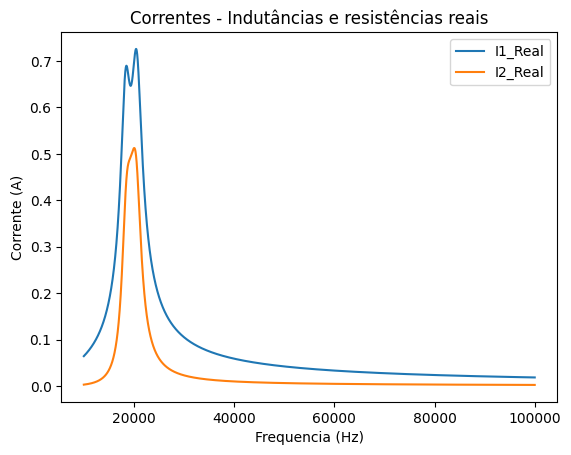

Corrente máxima no primário: 0.6855562705264306 A

Corrente máxima no secundário: 0.5561772939887453 A

A frequência em que a corrente é máxima é 20432.043204320435 Hz


In [22]:
lista_freq = np.linspace(10000, 100000, 10000)
maior_valor = 0
lista_i1 = []
lista_i2 = []
L = 0.0004387
C = 150e-9

for freq in lista_freq:
    I1, I2 = CalcularTransformador_projeto(5, 1, 1, 300, L, C, 0.2, freq)
    lista_i1.append(abs(I1))
    lista_i2.append(abs(I2))


# ---------------- Valores Reais ---------------- 

lista_i1_2 = []
lista_i2_2 = []
R1 = 1.638
R2 = 1.37
L1 = 0.0004523
L2 = 0.0004528
Rc = 400
K_ideal = 0.13013013013013014 # Está no último bloco do código - f = 20000 kHz

for freq in lista_freq:
    I1_1, I2_1 = CalcularTransformador_projeto2(5, R1*1.4, R2*1.4, Rc, L1, L2, C, K_ideal, freq)
    lista_i1_2.append(abs(I1_1))
    lista_i2_2.append(abs(I2_1))

plt.title('Correntes - Indutâncias e resistências reais')
plt.plot(lista_freq, lista_i1_2, label="I1_Real")
plt.plot(lista_freq, lista_i2_2, label="I2_Real")
plt.xlabel("Frequencia (Hz)")
plt.ylabel("Corrente (A)")
plt.legend()
plt.show()

print(f'Corrente máxima no primário: {max(lista_i1)} A\n')
print(f'Corrente máxima no secundário: {max(lista_i2)} A\n')
print(f'A frequência em que a corrente é máxima é {lista_freq[lista_i1_2.index(max(lista_i1_2))]} Hz')

### 4. Construção de um gráfico do módulo da tensão $V_2$ pela frequência de ressonância, para 6 diferentes indutâncias e para 5 diferentes capacitores (Análise para chegar na nossa montagem da bobina)

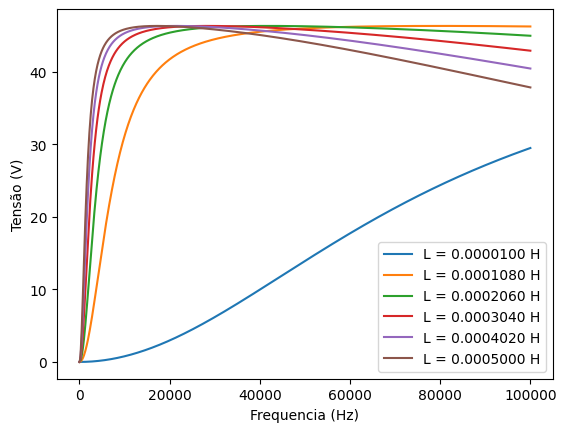

In [23]:
#Criando uma lista para as legendas do gráfico
lista_L = np.linspace(10e-6, 500e-6, 6)
lista_legendas = []
for l in lista_L:
    legenda = str("L = {:.7f} H".format(l))
    lista_legendas.append(legenda)

Rc = 400
lista_freq_r = np.linspace(1, 100000, 1000)
lista_V2 = []

for l in lista_L:
    lista_V2_individual = []
    for freq in lista_freq_r:
        # Cálculo da capacitância
        C = 1/((freq**2)*(4*pi**2)*l)
        I1, I2 = CalcularTransformador_projeto(10, 1, 1, Rc, l, C, 0.2, freq)
        #Cálculo da tensão no secundário
        XC = 1/(1j*freq*2*pi*C)
        V2 = I2*((Rc*XC)/(Rc+XC))
        lista_V2_individual.append(abs(V2))
    lista_V2.append(lista_V2_individual)

# Plot de V2 por freq para cada valor de L
lista_L = list(lista_L)
i = 0
for lista_V2_individual in lista_V2:
    # lista_freq_r = lista_freq_r[]
    # lista_V2_individual = lista_V2_individual[]
    plt.plot(lista_freq_r, lista_V2_individual, label=lista_legendas[i])
    i += 1
plt.xlabel("Frequencia (Hz)")
plt.ylabel("Tensão (V)")
#plt.xlim(1, 20000)
plt.legend()
plt.show()


Capacitor de capacitância: 0.1e-6 F
Frequência em que a tensão no secundário é máxima: 29430.135135135133

Capacitor de capacitância: 150e-9 F
Frequência em que a tensão no secundário é máxima: 19620.42342342342

Capacitor de capacitância: 1e-6 F
Frequência em que a tensão no secundário é máxima: 2903.873873873874

Capacitor de capacitância: 4.7e-6 F
Frequência em que a tensão no secundário é máxima: 601.5945945945946

Capacitor de capacitância: 0.47e-6 F
Frequência em que a tensão no secundário é máxima: 6307.243243243242



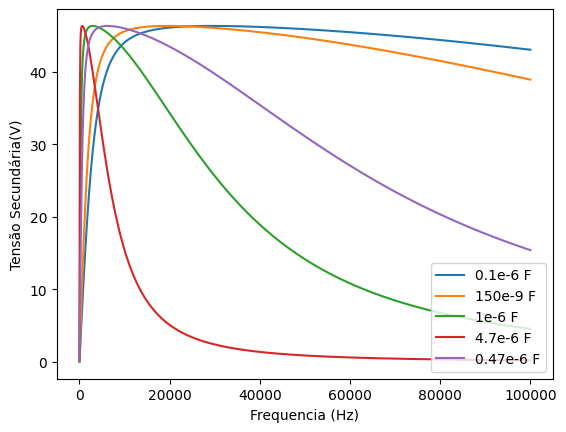

In [24]:
Rc = 400
lista_freq_r = np.linspace(1, 100000, 1000)
lista_V2 = []
lista_C = [0.1e-6, 150e-9, 1e-6, 4.7e-6, 0.47e-6]
for C in lista_C:
    lista_V2_individual = []
    for freq in lista_freq_r:
        # Cálculo da capacitância
        L = 1/((freq**2)*(4*pi**2)*C)
        I1, I2 = CalcularTransformador_projeto(10, 1, 1, Rc, L, C, 0.2, freq)
        #Cálculo da tensão no secundário
        XC = 1/(1j*freq*2*pi*C)
        V2 = I2*((Rc*XC)/(Rc+XC))
        lista_V2_individual.append(abs(V2))
    lista_V2.append(lista_V2_individual)

# Criando uma lista para as legendas do gráfico
lista_legendas = ["0.1e-6 F", "150e-9 F", "1e-6 F", "4.7e-6 F", "0.47e-6 F"]

# Plot de V2 por freq para cada valor de L
i = 0
for lista_V2_individual in lista_V2:
    print(f'Capacitor de capacitância: {lista_legendas[i]}')
    index_max = lista_V2_individual.index(max(lista_V2_individual))
    print(f'Frequência em que a tensão no secundário é máxima: {lista_freq_r[index_max]}\n')
    plt.plot(lista_freq_r, lista_V2_individual, label=lista_legendas[i])
    i += 1
plt.xlabel("Frequencia (Hz)")
plt.ylabel("Tensão Secundária(V)")
# plt.xlim(1, 20000)
plt.legend(loc='lower right')
plt.show()

In [25]:
# Usaremos o capacitor de 150nF (F pico = 19.620,42 Hz) para calcular a indutância
C = 150e-9
freq = 19620.42342342342
L = 1/((freq**2)*(4*pi**2)*C)
print(f'A indutância para o capacitor de 150nF: {L:.7f} H')
print(f'A indutância para o capacitor de 150nF (aproximado): {L*1000:.2f} mH')

A indutância para o capacitor de 150nF: 0.0004387 H
A indutância para o capacitor de 150nF (aproximado): 0.44 mH


### 5. Construção de gráficos das potências e da eficiência em função da frequência

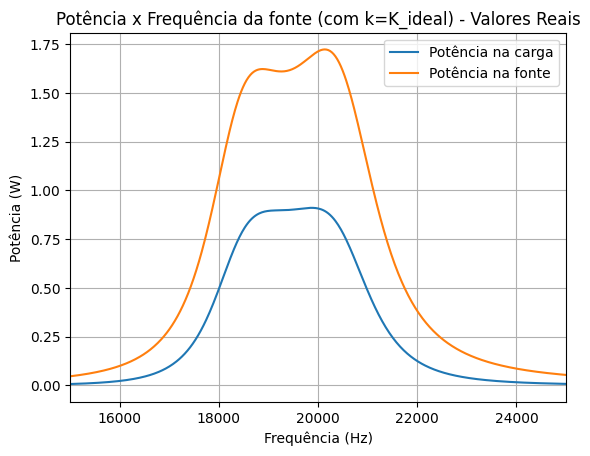

Potência máxima para k=K_ideal: 0.91 W


In [26]:
lista_iRC = []
lista_eficiencia = []
lista_potencia_carga = []
lista_potencia_fonte = []

lista_potencia_carga_2 = []
lista_potencia_fonte_2 = []
lista_eficiencia_2 = []

L = 0.0004387
C = 150e-9
Rc = 400
Uf = rect(5, 0)

lista_freq = np.linspace(10e3, 200e3, 10500)

#Calculando potência e eficiência em função da frequência.
for f in lista_freq:
    i1, i2 = CalcularTransformador_projeto(Uf, 1, 1, Rc, L, C, 0.2, f)
    w = 2*pi*f
    Pot = (Calcula_Potencia(Uf, i1)).real
    lista_potencia_fonte.append(Pot)

    Z_eq_carga = ((1/(1j*w*C))*Rc)/((1/(1j*w*C))+Rc)
    V_carga = i2*Z_eq_carga
    I_Rc = V_carga/Rc
    Pot_carga = (Calcula_Potencia(V_carga, I_Rc)).real

    #Adiciona os resultados na lista
    lista_potencia_carga.append(Pot_carga)
    lista_eficiencia.append(calcula_eficiencia(Pot, Pot_carga))


    # ------------------- Valores Reais ------------------- #

    #Calculando novamente para os valores reais
    i1_2, i2_2 = CalcularTransformador_projeto2(Uf, R1*1.4, R2*1.4, Rc, L1, L2, C, K_ideal, f)
    Pot_2 = (Calcula_Potencia(Uf, i1_2)).real
    lista_potencia_fonte_2.append(Pot_2)

    Z_eq_carga_2 = ((1/(1j*w*C))*Rc)/((1/(1j*w*C))+Rc)
    V_carga_2 = i2_2*Z_eq_carga_2
    I_Rc_2 = V_carga_2/Rc
    Pot_carga_2 = (Calcula_Potencia(V_carga_2, I_Rc_2)).real

    #Adiciona os resultados na lista
    lista_potencia_carga_2.append(Pot_carga_2)
    lista_eficiencia_2.append(calcula_eficiencia(Pot_2, Pot_carga_2))


#Plotando a eficiência em função da frequência - Valores Reais
plt.plot(lista_freq, lista_potencia_carga_2, label="Potência na carga")
plt.plot(lista_freq, lista_potencia_fonte_2, label="Potência na fonte")
plt.title("Potência x Frequência da fonte (com k=K_ideal) - Valores Reais")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Potência (W)")
plt.xlim(15000, 25000)
plt.legend()
plt.grid(True)
plt.show()

print(f'Potência máxima para k=K_ideal: {max(lista_potencia_carga_2):.2f} W')

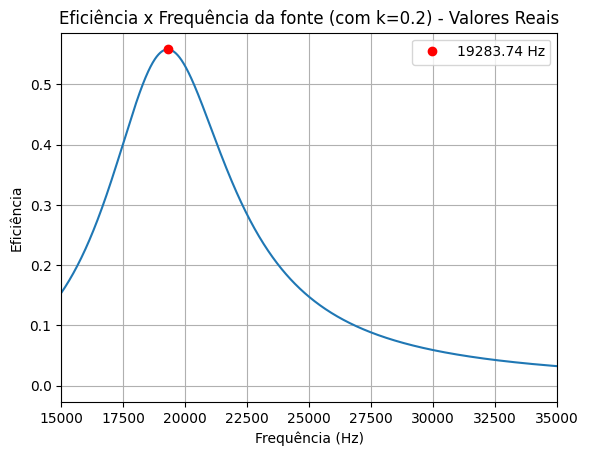

A eficiência máxima para k=K_ideal: 56.00000000000001%


In [27]:
#Utilizando a lista de eficiência do item anterior - Valores Reais
plt.plot(lista_freq, lista_eficiencia_2)
i = lista_eficiencia_2.index(max(lista_eficiencia_2))
plt.plot(lista_freq[i], lista_eficiencia_2[i], 'ro', label=f'{round(lista_freq[i], 2)} Hz')
plt.title("Eficiência x Frequência da fonte (com k=0.2) - Valores Reais")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Eficiência")
plt.xlim(15000, 35000)
plt.legend()
plt.grid(True)
plt.show()

print(f'A eficiência máxima para k=K_ideal: {round(max(lista_eficiencia_2), 2)*100}%')


### 6. Construção de um gráfico que relacione o valor de pico da tensão no secundário (no resistor $𝑅_𝐶$) com o coeficiente de acoplamento $k$

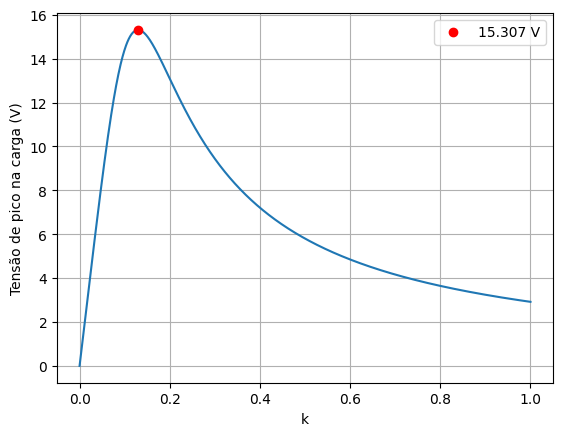

O valor de k para a tensão de pico na carga ser máxima é 0.13013013013013014

A tensão de pico na carga é 15.30656502896227 V

A resistência utilizada para o modelo para o primário e para o secundário foi de 2.293 e 1.918 Ohms, respectivamente.


In [28]:
# Retomando Valores Reais
C = 150e-9
Rc = 300
Uf = rect(5, 0)
V_entrada = 5*2/pi

freq_r = 1/(2*pi*sqrt(L*C))
lista_k = np.linspace(0, 1, 1000)
lista_tensao_pico = []
lista_tensao_pico_2 = []

for k_novo in lista_k:
    i1, i2 = CalcularTransformador_projeto(Uf, 1, 1, Rc, L, C, k_novo, freq_r)
    w = 2*pi*freq_r
    Z_eq_carga = ((1/(1j*w*C))*Rc)/((1/(1j*w*C))+Rc)
    V_carga = i2*Z_eq_carga
    lista_tensao_pico.append(abs(V_carga))


    # ------------------- Valores Reais ------------------- #

    f2 = 20000 #Frequência real de operação - 20kHz
    i1_2, i2_2 = CalcularTransformador_projeto2(V_entrada, R1*1.4, R2*1.4, Rc, L1, L2, C, k_novo, f2)
    w_2 = 2*pi*f2
    Z_eq_carga_2 = ((1/(1j*w_2*C))*Rc)/((1/(1j*w_2*C))+Rc)
    V_carga_2 = i2_2*Z_eq_carga_2
    lista_tensao_pico_2.append(abs(V_carga_2))


i = lista_tensao_pico_2.index(max(lista_tensao_pico_2))

plt.plot(lista_k, lista_tensao_pico_2)
plt.plot(lista_k[i], lista_tensao_pico_2[i], 'ro', label=f'{round(lista_tensao_pico_2[i], 3)} V')
#plt.title("Tensão de pico na carga x k - Valores Reais")
plt.xlabel("k")
plt.ylabel("Tensão de pico na carga (V)")
plt.legend()
plt.grid(True)
plt.show()

i = lista_tensao_pico_2.index(max(lista_tensao_pico_2))
print(f'O valor de k para a tensão de pico na carga ser máxima é {lista_k[i]}\n')
print(f'A tensão de pico na carga é {max(lista_tensao_pico_2)} V\n')
print(f'A resistência utilizada para o modelo para o primário e para o secundário foi de {R1*1.4 :.3f} e {R2*1.4 :.3f} Ohms, respectivamente.')
